In [1]:
import os
import pandas as pd
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
IMG_SIZE=512
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
def circle_crop(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img 
    
def preprocess_image_with_ben(path, sigmaX=50):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

def preprocess_image_with_benandkeepgreen(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    green_channel = image[:, :, 1] 
    esihe_image = cv2.equalizeHist(green_channel)
    return esihe_image

def equalizeafterproprocess(path,sigmaX=10):
    img = cv2.imread(path)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    b, g, r = cv2.split(img)
    # Extract the green channel
    equalized_b = cv2.equalizeHist(b)
    equalized_g = cv2.equalizeHist(g)
    equalized_r = cv2.equalizeHist(r)
    equalized_image = cv2.merge((equalized_b, equalized_g, equalized_r))
    equalized_image = cv2.resize(equalized_image, (IMG_SIZE, IMG_SIZE))
    return equalized_image 

def claheafterpreprocess(img, sigmaX=10):   
    """
    Create circular crop around image centre    
    """    
    
    img = cv2.imread(img)
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    clahe_mat = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = clahe_mat.apply(img)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        img[:, :, 0] = clahe_mat.apply(img[:, :, 0])
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    return img 

IMG_SIZE = 512
scale = 300

def scaleRadius(img, scale):
    x = img[img.shape[0] // 2, :, :].sum(1)
    r = (x > x.mean() / 10).sum() / 2
    if r == 0:
        s = 1.0
    else:
        s = scale * 1.0 / r
    output_size = (int(img.shape[1] * s), int(img.shape[0] * s))
    return cv2.resize(img, output_size)

def preprocess_image_with_defaultben(path):
    image = cv2.imread(path)
    image = scaleRadius(image, scale)
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0, 0), scale / 30), -4, 128)
    b = np.zeros(image.shape, dtype=np.uint8)
    center = (image.shape[1] // 2, image.shape[0] // 2)
    cv2.circle(b, center, int(scale * 0.9), (1, 1, 1), -1, 8, 0)
    image = image * b + 128 * (1 - b)
    return image

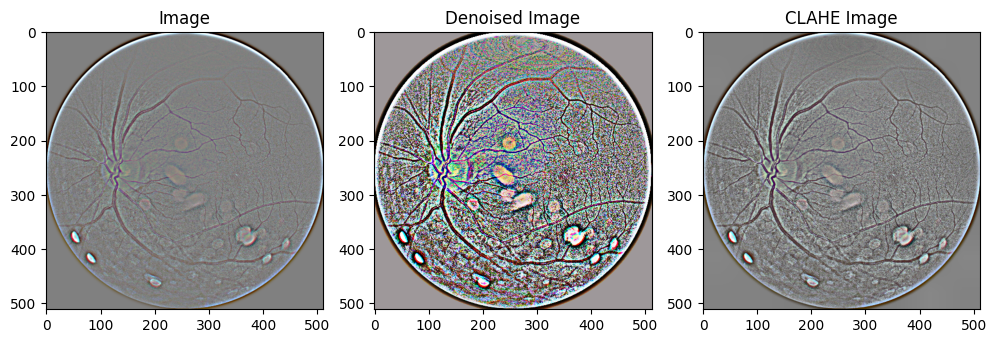

In [5]:
import cv2
from bm3d import bm3d

# Load the image
image = cv2.imread(r"E:\FYP\dataset\default dataset\DeepDRiD-master\regular_fundus_images\regular-fundus-training\1\1_l1.jpg")
#image = crop_image_from_gray(image)

#image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
#denoised_image=circle_crop(r"E:\FYP\dataset\default dataset\DeepDRiD-master\regular_fundus_images\regular-fundus-training\1\1_l1.jpg",5)
denoised_image2=circle_crop(r"E:\FYP\dataset\default dataset\DeepDRiD-master\regular_fundus_images\regular-fundus-training\1\1_l1.jpg",10)
#denoised_image3=circle_crop(r"E:\FYP\dataset\default dataset\DeepDRiD-master\regular_fundus_images\regular-fundus-training\1\1_l1.jpg",15)

clahe_mat = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img=denoised_image2
if len(img.shape) == 2 or img.shape[2] == 1:
    img = clahe_mat.apply(img)
else:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    img[:, :, 0] = clahe_mat.apply(img[:, :, 0])
    img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)

b, g, r = cv2.split(denoised_image2)
# Extract the green channel
equalized_b = cv2.equalizeHist(b)
equalized_g = cv2.equalizeHist(g)
equalized_r = cv2.equalizeHist(r)
equalized_image = cv2.merge((equalized_b, equalized_g, equalized_r))


esihe_image = circle_crop(r"E:\FYP\dataset\default dataset\DeepDRiD-master\regular_fundus_images\regular-fundus-training\1\1_l1.jpg")
image_rgb1 = cv2.cvtColor(denoised_image2, cv2.COLOR_BGR2RGB)
image_rgb2 = cv2.cvtColor(equalized_image, cv2.COLOR_BGR2RGB)
image_rgb3 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_rgb1)
plt.title('Image')

plt.subplot(1, 3, 2)
plt.imshow(image_rgb2)
plt.title('Denoised Image')

plt.subplot(1, 3, 3)
plt.imshow(image_rgb3)
plt.title('CLAHE Image')

plt.tight_layout()
plt.show()


# kaggle eyepacs

In [3]:
base_image_dir = os.path.join('..', 'dataset','kaggle diabetic-retinopathy-detection')
new_image_dir1 = os.path.join('..', 'dataset','ben processed and equalize', 'kaggletrain')
new_image_dir2 = os.path.join('..', 'dataset','Ben processed and clahe', 'kaggletest')
retina_df1 = pd.read_csv(os.path.join(base_image_dir, 'trainLabels.csv'))
retina_df2 = pd.read_csv(os.path.join(base_image_dir, 'retinopathy_solution.csv'))
header = ['image', 'level']  # Replace with your desired column names
train_image_dir= os.path.join(base_image_dir,'train')
test_image_dir= os.path.join(base_image_dir,'test','test')
#jpeg image
retina_df1['image_path'] = retina_df1['image'].map(lambda x: train_image_dir+'\\'+x+'.jpeg')
retina_df2['image_path'] = retina_df2['image'].map(lambda x: test_image_dir+'\\'+x+'.jpeg')
retina_df1['newpath'] = retina_df1['image'].map(lambda x: os.path.join(new_image_dir1,str(retina_df1['level'][retina_df1[retina_df1['image']==x].index.values].values[0]),x))
retina_df2['newpath'] = retina_df2['image'].map(lambda x: os.path.join(new_image_dir2,str(retina_df2['level'][retina_df2[retina_df2['image']==x].index.values].values[0]),x))


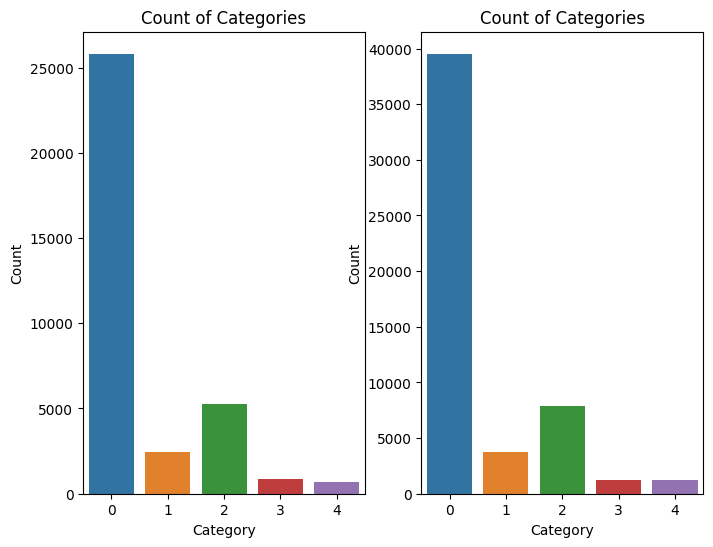

In [20]:
plt.figure(figsize=(8, 6))
plt.subplot(1,2,1)
sns.countplot(data=retina_df1, x='level')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Categories')

plt.subplot(1,2,2)
sns.countplot(data=retina_df2, x='level')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Categories')
plt.show()
plt.show()

In [4]:

for i,image_path in enumerate(tqdm(retina_df2['image_path'])):
    image_dir=retina_df2.iloc[i][-1]
    cv2.imwrite(image_dir+".jpeg",claheafterpreprocess(image_path))

100%|██████████| 53576/53576 [4:47:21<00:00,  3.11it/s]   


# fgadr

In [14]:
base_image_dir = os.path.join('..', 'dataset','default dataset', 'FGADR-Seg-set_Release','Seg-set')
new_image_dir1 = os.path.join('..', 'dataset','Ben processed and clahe', 'fgadr')
retina_df1 = pd.read_csv(os.path.join(base_image_dir, 'DR_Seg_Grading_Label.csv'), header=None)
header = ['image_id', 'dr rating']  # Replace with your desired column names
retina_df1.columns = header
image_dir= os.path.join(base_image_dir,'Original_Images')
retina_df1['image_path'] = retina_df1['image_id'].map(lambda x: image_dir+'\\'+x)
retina_df1['newpath'] = retina_df1['image_id'].map(lambda x: os.path.join(new_image_dir1,str(retina_df1['dr rating'][retina_df1[retina_df1['image_id']==x].index.values].values[0]),x))
for i,image_path in enumerate(tqdm(retina_df1['image_path'])):
    image_dir=retina_df1.iloc[i][-1]
    cv2.imwrite(image_dir+".png",claheafterpreprocess(image_path))

100%|██████████| 1842/1842 [04:43<00:00,  6.49it/s]


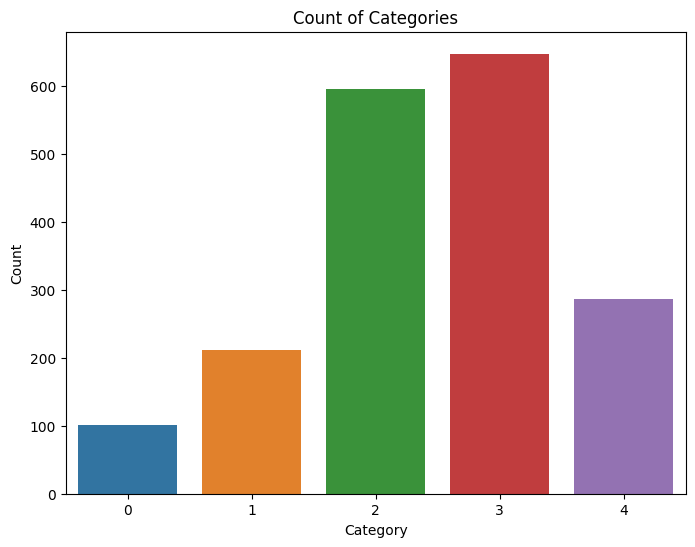

In [3]:
base_image_dir = os.path.join('..', 'dataset','default dataset', 'FGADR-Seg-set_Release','Seg-set')
new_image_dir1 = os.path.join('..', 'dataset','Ben processed and clahe', 'fgadr')
retina_df1 = pd.read_csv(os.path.join(base_image_dir, 'DR_Seg_Grading_Label.csv'), header=None)
header = ['image_id', 'dr rating']  # Replace with your desired column names
retina_df1.columns = header
image_dir= os.path.join(base_image_dir,'Original_Images')
retina_df1['image_path'] = retina_df1['image_id'].map(lambda x: image_dir+'\\'+x)
retina_df1['newpath'] = retina_df1['image_id'].map(lambda x: os.path.join(new_image_dir1,str(retina_df1['dr rating'][retina_df1[retina_df1['image_id']==x].index.values].values[0]),x))

plt.figure(figsize=(8, 6))
sns.countplot(data=retina_df1, x='dr rating')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Categories')
plt.show()

# idrid

In [7]:
base_image_dir = os.path.join('..', 'dataset','default dataset', 'idrid','B. Disease Grading')
new_image_dir1 = os.path.join('..', 'dataset','ben processed and equalize', 'idridtrain')
new_image_dir2 = os.path.join('..', 'dataset','Ben processed and clahe', 'idridtest')
retina_df1 = pd.read_csv(os.path.join(base_image_dir,'2. Groundtruths', 'a. IDRiD_Disease Grading_Training Labels.csv'))
retina_df2 = pd.read_csv(os.path.join(base_image_dir,'2. Groundtruths', 'b. IDRiD_Disease Grading_Testing Labels.csv'))
train_image_dir=os.path.join(base_image_dir,'1. Original Images','a. Training Set')
test_image_dir=os.path.join(base_image_dir,'1. Original Images','b. Testing Set')
#Retinopathy grade
retina_df1['image_path'] = retina_df1['Image name'].map(lambda x: train_image_dir+"\\"+x+'.jpg')
retina_df1['newpath'] = retina_df1['Image name'].map(lambda x: os.path.join(new_image_dir1,str(retina_df1['Retinopathy grade'][retina_df1[retina_df1['Image name']==x].index.values].values[0]),
                                                         '{}.png'.format(x)))
retina_df2['image_path'] = retina_df2['Image name'].map(lambda x: train_image_dir+"\\"+x+'.jpg')
retina_df2['newpath'] = retina_df2['Image name'].map(lambda x: os.path.join(new_image_dir2,str(retina_df2['Retinopathy grade'][retina_df2[retina_df2['Image name']==x].index.values].values[0]),
                                                         '{}.png'.format(x)))

for i,image_path in enumerate(tqdm(retina_df2['image_path'])):
    image_dir=retina_df2.iloc[i][-1]
    cv2.imwrite(image_dir+".png",claheafterpreprocess(image_path))

100%|██████████| 103/103 [00:37<00:00,  2.77it/s]


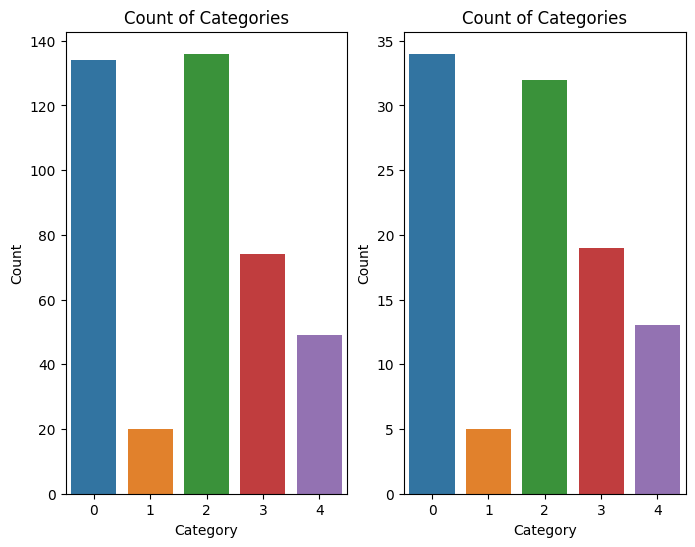

In [5]:
base_image_dir = os.path.join('..', 'dataset','default dataset', 'idrid','B. Disease Grading')
new_image_dir1 = os.path.join('..', 'dataset','ben processed and equalize', 'idridtrain')
new_image_dir2 = os.path.join('..', 'dataset','Ben processed and clahe', 'idridtest')
retina_df1 = pd.read_csv(os.path.join(base_image_dir,'2. Groundtruths', 'a. IDRiD_Disease Grading_Training Labels.csv'))
retina_df2 = pd.read_csv(os.path.join(base_image_dir,'2. Groundtruths', 'b. IDRiD_Disease Grading_Testing Labels.csv'))
train_image_dir=os.path.join(base_image_dir,'1. Original Images','a. Training Set')
test_image_dir=os.path.join(base_image_dir,'1. Original Images','b. Testing Set')
#Retinopathy grade
retina_df1['image_path'] = retina_df1['Image name'].map(lambda x: train_image_dir+"\\"+x+'.jpg')
retina_df1['newpath'] = retina_df1['Image name'].map(lambda x: os.path.join(new_image_dir1,str(retina_df1['Retinopathy grade'][retina_df1[retina_df1['Image name']==x].index.values].values[0]),
                                                         '{}.png'.format(x)))
retina_df2['image_path'] = retina_df2['Image name'].map(lambda x: train_image_dir+"\\"+x+'.jpg')
retina_df2['newpath'] = retina_df2['Image name'].map(lambda x: os.path.join(new_image_dir2,str(retina_df2['Retinopathy grade'][retina_df2[retina_df2['Image name']==x].index.values].values[0]),
                                                         '{}.png'.format(x)))
plt.figure(figsize=(8, 6))
plt.subplot(1,2,1)
sns.countplot(data=retina_df1, x='Retinopathy grade')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Categories')

plt.subplot(1,2,2)
sns.countplot(data=retina_df2, x='Retinopathy grade')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Categories')
plt.show()

# deepdrid

In [48]:
base_image_dir = os.path.join('..', 'dataset','default dataset', 'DeepDRiD-master','regular_fundus_images')
new_image_dir1 = os.path.join('..', 'dataset','kaggle ben', 'deepdridtrainprocessed')
new_image_dir2 = os.path.join('..', 'dataset','kaggle ben', 'deepdridvalidprocessed')
new_image_dir3 = os.path.join('..', 'dataset','kaggle ben', 'deepdridchallengeprocessed')

retina_df1 = pd.read_csv(os.path.join(base_image_dir,'regular-fundus-training', 'regular-fundus-training.csv'))

retina_df1['dr rating'] = retina_df1.apply(lambda row: row['left_eye_DR_Level'] if pd.notnull(row['left_eye_DR_Level'])
                                  else row['right_eye_DR_Level'], axis=1).astype(int)
retina_df1['image_path'] = retina_df1['image_path'].map(lambda x: base_image_dir+x)
retina_df1['newpath'] = retina_df1['image_id'].map(lambda x: os.path.join(new_image_dir1,str(retina_df1['dr rating'][retina_df1[retina_df1['image_id']==x].index.values].values[0]),
                                                         '{}.jpeg'.format(x)))

retina_df2 = pd.read_csv(os.path.join(base_image_dir,'regular-fundus-validation', 'regular-fundus-validation.csv'))
retina_df2['dr rating'] = retina_df2.apply(lambda row: row['left_eye_DR_Level'] if pd.notnull(row['left_eye_DR_Level'])
                                  else row['right_eye_DR_Level'], axis=1).astype(int)
retina_df2['image_path'] = retina_df2['image_path'].map(lambda x: base_image_dir+x)
retina_df2['newpath'] = retina_df2['image_id'].map(lambda x: os.path.join(new_image_dir2,str(retina_df2['dr rating'][retina_df2[retina_df2['image_id']==x].index.values].values[0]),
                                                         '{}.jpeg'.format(x)))

retina_df3 = pd.read_csv(os.path.join(base_image_dir,'Online-Challenge1&2-Evaluation', 'Challenge1_labels.csv'))
retina_df3.rename(columns={'DR_Levels':'dr rating'},inplace=True)
retina_df3['image_path'] = retina_df3['image_id'].map(lambda x: os.path.join(base_image_dir,'Online-Challenge1&2-Evaluation','Images',x.split("_")[0],
                                                         '{}.jpg'.format(x)))
retina_df3['newpath'] = retina_df3['image_id'].map(lambda x: os.path.join(new_image_dir3,str(retina_df3['dr rating'][retina_df3[retina_df3['image_id']==x].index.values].values[0]),
                                                         '{}.jpeg'.format(x)))

for i,image_path in enumerate(tqdm(retina_df1['image_path'])):
    image_dir=retina_df1.iloc[i][11]
    cv2.imwrite(image_dir+".jpeg",preprocess_image_with_ben(image_path))

for i,image_path in enumerate(tqdm(retina_df2['image_path'])):
    image_dir=retina_df2.iloc[i][11]
    cv2.imwrite(image_dir+".jpeg",preprocess_image_with_ben(image_path))

for i,image_path in enumerate(tqdm(retina_df3['image_path'])):
    image_dir=retina_df3.iloc[i][3]
    cv2.imwrite(image_dir+".jpeg",preprocess_image_with_ben(image_path))

100%|██████████| 400/400 [00:36<00:00, 10.83it/s]


0    914
2    398
3    354
1    222
4    112
Name: dr rating, dtype: int64


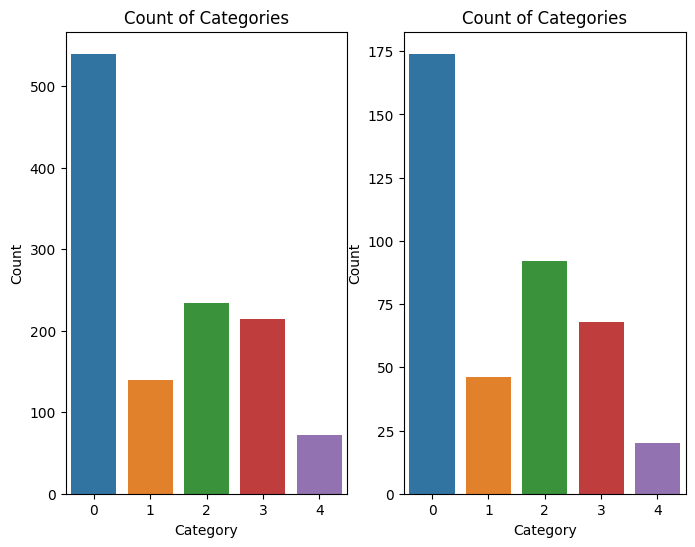

In [4]:
selected_columns =['image_id','image_path','dr rating','newpath']
retina_df=pd.concat([retina_df1[selected_columns],retina_df2[selected_columns],retina_df3[selected_columns]])
# Display the count of each category
count = retina_df['dr rating'].value_counts()
print(count)

# Plot the count using a bar plot
plt.figure(figsize=(8, 6))
plt.subplot(1,2,1)
sns.countplot(data=retina_df1, x='dr rating')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Categories')

plt.subplot(1,2,2)
sns.countplot(data=retina_df2, x='dr rating')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Categories')
plt.show()
plt.show()

# retinal lesion

In [11]:
base_image_dir = os.path.join('..', 'dataset','default dataset', 'retinal-lesions-v20191227')
new_image_dir = os.path.join('..', 'dataset','Ben processed and clahe', 'retinallesion')
retina_df4 = pd.read_csv(os.path.join(base_image_dir, 'dr_grades.csv'))
retina_df4['image_path'] = retina_df4['image id'].map(lambda x: os.path.join(base_image_dir,'images_896x896',
                                                         '{}.jpg'.format(x)))
retina_df4.rename(columns={'our label':'dr rating','image id':'image_id'},inplace=True)
retina_df4['newpath'] = retina_df4['image_id'].map(lambda x: os.path.join(new_image_dir,str(retina_df4['dr rating'][retina_df4[retina_df4['image_id']==x].index.values].values[0]),
                                                         'retinal-lesion_'+'{}.jpg'.format(x)))

for i,image_path in enumerate(tqdm(retina_df4['image_path'])):
    image_dir=retina_df4.iloc[i][4]
    cv2.imwrite(image_dir+".png",claheafterpreprocess(image_path))

100%|██████████| 1593/1593 [01:42<00:00, 15.52it/s]


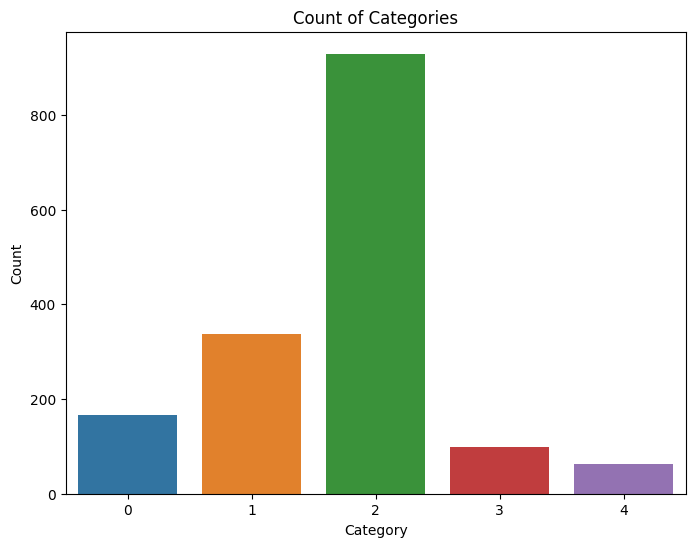

In [5]:
# Plot the count using a bar plot
plt.figure(figsize=(8, 6))
sns.countplot(data=retina_df4, x='dr rating')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Categories')
plt.show()

# aptos 2019

In [12]:
base_image_dir = os.path.join('..', 'dataset','default dataset', 'aptos2019-blindness-detection')
new_image_dir = os.path.join('..', 'dataset','Ben processed and clahe', 'aptos2019')
retina_df5 = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
retina_df5['image_path'] = retina_df5['id_code'].map(lambda x: os.path.join(base_image_dir,'train_images',
                                                         '{}.png'.format(x)))
retina_df5.rename(columns={'diagnosis':'dr rating','id_code':'image_id'},inplace=True)
retina_df5['newpath'] = retina_df5['image_id'].map(lambda x: os.path.join(new_image_dir,str(retina_df5['dr rating'][retina_df5[retina_df5['image_id']==x].index.values].values[0]),
                                                         'aptos2019_'+'{}.jpeg'.format(x)))

for i,image_path in enumerate(tqdm(retina_df5['image_path'])):
    image_dir=retina_df5.iloc[i][3]
    cv2.imwrite(image_dir+".jpeg",claheafterpreprocess(image_path))

100%|██████████| 3662/3662 [14:01<00:00,  4.35it/s]


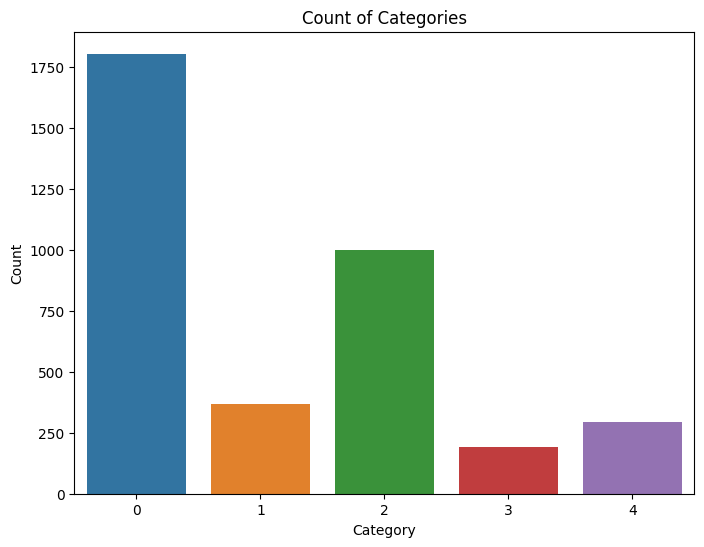

In [6]:
base_image_dir = os.path.join('..', 'dataset','default dataset', 'aptos2019-blindness-detection')
new_image_dir = os.path.join('..', 'dataset', 'aptos2019processed')
retina_df5 = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
retina_df5['image_path'] = retina_df5['id_code'].map(lambda x: os.path.join(base_image_dir,'train_images',
                                                         '{}.png'.format(x)))
retina_df5.rename(columns={'diagnosis':'dr rating','id_code':'image_id'},inplace=True)
retina_df5['newpath'] = retina_df5['image_id'].map(lambda x: os.path.join(new_image_dir,str(retina_df5['dr rating'][retina_df5[retina_df5['image_id']==x].index.values].values[0]),
                                                         'aptos2019_'+'{}.jpeg'.format(x)))

# Plot the count using a bar plot
plt.figure(figsize=(8, 6))
sns.countplot(data=retina_df5, x='dr rating')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Categories')
plt.show()

# ddr dataset

In [21]:
base_image_dir = os.path.join('..', 'dataset','default dataset', 'ddr','DDR-dataset','DDR-dataset','DR_grading')
new_image_dir1 = os.path.join('..', 'dataset','ben processed and equalize', 'ddrtest')
new_image_dir2 = os.path.join('..', 'dataset','ben processed and equalize', 'ddrtrain')
new_image_dir3 = os.path.join('..', 'dataset','ben processed and equalize', 'ddrvalid')
ddr_test = pd.read_csv(os.path.join(base_image_dir,'test.txt'), delimiter=' ', header=None, names=['image_path', 'dr rating'])
ddr_test = ddr_test[ddr_test['dr rating'] != 5]
ddr_train = pd.read_csv(os.path.join(base_image_dir,'train.txt'), delimiter=' ', header=None, names=['image_path', 'dr rating'])
ddr_train = ddr_train[ddr_train['dr rating'] != 5]
ddr_valid = pd.read_csv(os.path.join(base_image_dir,'valid.txt'), delimiter=' ', header=None, names=['image_path', 'dr rating'])
ddr_valid = ddr_valid[ddr_valid['dr rating'] != 5]
base_image_dir = os.path.join('..', 'dataset','default dataset', 'ddr','DDR-dataset','DDR-dataset','DR_grading','test')
ddr_test['image_path'] = ddr_test['image_path'].map(lambda x: base_image_dir+'\\'+x)
ddr_test['image_id'] = ddr_test['image_path'].map(lambda x: x.split('\\')[-1].split('.')[0])
ddr_test['newpath'] = ddr_test['image_id'].map(lambda x: os.path.join(new_image_dir1,str(ddr_test['dr rating'][ddr_test[ddr_test['image_id']==x].index.values].values[0]),
                                                         '{}.jpeg'.format(x)))
base_image_dir = os.path.join('..', 'dataset','default dataset', 'ddr','DDR-dataset','DDR-dataset','DR_grading','train')
ddr_train['image_path'] = ddr_train['image_path'].map(lambda x: base_image_dir+'\\'+x)
ddr_train['image_id'] = ddr_train['image_path'].map(lambda x: x.split('\\')[-1].split('.')[0])
ddr_train['newpath'] = ddr_train['image_id'].map(lambda x: os.path.join(new_image_dir2,str(ddr_train['dr rating'][ddr_train[ddr_train['image_id']==x].index.values].values[0]),
                                                         '{}.jpeg'.format(x)))
base_image_dir = os.path.join('..', 'dataset','default dataset', 'ddr','DDR-dataset','DDR-dataset','DR_grading','valid')
ddr_valid['image_path'] = ddr_valid['image_path'].map(lambda x: base_image_dir+'\\'+x)
ddr_valid['image_id'] = ddr_valid['image_path'].map(lambda x: x.split('\\')[-1].split('.')[0])
ddr_valid['newpath'] = ddr_valid['image_id'].map(lambda x: os.path.join(new_image_dir3,str(ddr_valid['dr rating'][ddr_valid[ddr_valid['image_id']==x].index.values].values[0]),
                                                         '{}.jpeg'.format(x)))

for i,image_path in enumerate(tqdm(ddr_test['image_path'])):
    image_dir=ddr_test.iloc[i][3]
    cv2.imwrite(image_dir+".jpeg",equalizeafterproprocess(image_path))

for i,image_path in enumerate(tqdm(ddr_train['image_path'])):
    image_dir=ddr_train.iloc[i][3]
    cv2.imwrite(image_dir+".jpeg",equalizeafterproprocess(image_path))

for i,image_path in enumerate(tqdm(ddr_valid['image_path'])):
    image_dir=ddr_valid.iloc[i][3]
    cv2.imwrite(image_dir+".jpeg",equalizeafterproprocess(image_path))

100%|██████████| 2503/2503 [07:31<00:00,  5.54it/s]


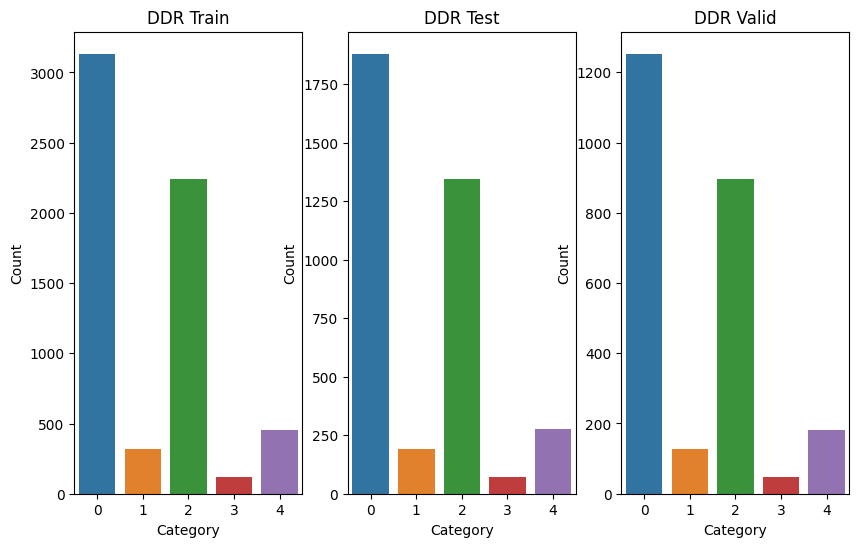

In [12]:
plt.figure(figsize=(10, 6))
plt.subplot(1,3,1)
sns.countplot(data=ddr_train, x='dr rating')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('DDR Train')

plt.subplot(1,3,2)
sns.countplot(data=ddr_test, x='dr rating')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('DDR Test')

plt.subplot(1,3,3)
sns.countplot(data=ddr_valid, x='dr rating')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('DDR Valid')
plt.show()